In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from classes import *
import keras
import matplotlib.pyplot as plt
import numpy as np

In [3]:
inputs, outputs = load_dataset(
    "benchmark_dataset_2d_1000dp_vary_perm inputs_gksi",
    dir = "../data",
    inputs_map = lambda x: x[:2]
    )
# inputs: pressure gradient, permeability, sdf, material_id
# outputs: temperature
coordinate_origin = np.array([23,9])
number, height, width,_ = inputs.shape
coords = coordinates(height,width, coordinate_origin)
repeat_coords = ops.repeat(coords[None,...], number, axis = 0)
inputs = ops.concatenate((inputs,repeat_coords), axis = -1)

split = 0.95
n_split = int(split * inputs.shape[0])
inputs_train, inputs_val = inputs[:n_split], inputs[n_split:]
outputs_train, outputs_val = outputs[:n_split], outputs[n_split:]
# now inputs is: pressure gradient, permeability, y, x
print(f"{inputs.shape=}")
print(f"{outputs.shape=}")
print(f"{inputs.device=}")

  0%|          | 0/999 [00:00<?, ?it/s]

inputs.shape=torch.Size([999, 256, 20, 4])
outputs.shape=torch.Size([999, 256, 20, 1])
inputs.device=device(type='cuda', index=0)


In [4]:
# This model gets x,y as input 
# as well as pressure gradient and permeability at the heatpumps location
nerf = keras.Sequential(
    [
        keras.layers.Input(shape=(4,)),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(1, activation="leaky_relu"),
    ],
    name="NeRF-like",
)
# nerf = keras.models.load_model("extended.keras")
# nerf.trainable = False

dist_model = keras.Sequential(
    [
        keras.layers.Input(shape=(height, width, 4)),
        keras.layers.Conv2D(16,3),
        keras.layers.Conv2D(4,3),
    ],
    name="Distortion Model",
)
edge_size = 2

complete_model = CompleteModel(
    coordinate_origin,
    nerf,
    dist_model,
    edge_size
)
complete_model.summary()

Model: "complete_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ NeRF-like (Sequential)          │ ?                      │        17,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Distortion Model (Sequential)   │ (None, 252, 16, 4)     │         1,172 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Local to Global (Sequential)    │ ?                      │         1,174 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Nerf wrapper (ApplyToImage)     │ (None, 256, 20, 1)     │        17,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │        17,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Values around pump              │ ?                      │   0 (unbuilt) │
│ (ValuesAroundPump)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,455 (72.09 KB)

 Trainable params: 18,455 (72.09 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
complete_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.MeanSquaredError(),
    metrics = ["mse"]
)

In [8]:
def manual_scheduler(epoch, lr):
    if epoch == 0:
        with open("lr.txt", "w") as f:
            f.write(f"{lr:.2e}")
        return lr
    else:
        with open("lr.txt") as f:
            try:
                lr = float(f.read())
            except:
                pass
        return lr


In [9]:
complete_model.fit(
    inputs_train,
    outputs_train[:,edge_size:-edge_size,edge_size:-edge_size,:],
    validation_data = (inputs_val, outputs_val[:,edge_size:-edge_size,edge_size:-edge_size,:]),
    batch_size=32,
    epochs=50000,
    shuffle = True,
    callbacks = [
        # CustomTensorboard("logs/complete_vary"),
        # SaveOutputsCallback(inputs_train[2:3]),
        # keras.callbacks.LearningRateScheduler(manual_scheduler)
    ],
    verbose = 0,
)

KeyboardInterrupt: 

In [50]:
# complete_model.save("complete_vary.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


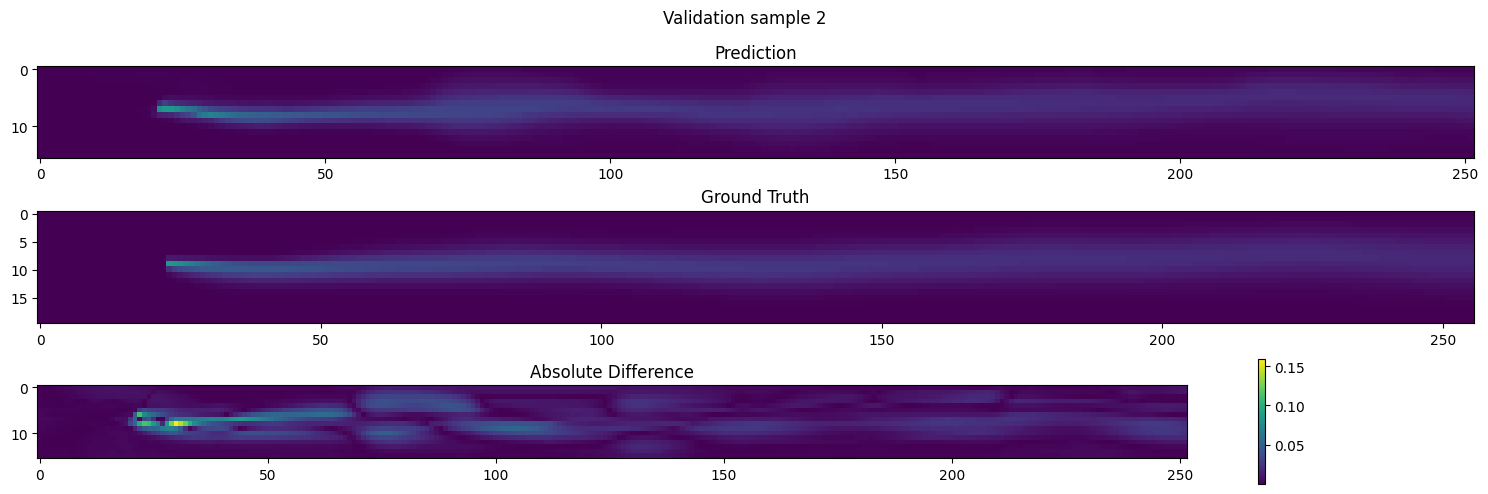

In [14]:
index = 2
prediction = complete_model.predict(inputs_val[index:index+1])[0]
gt = outputs_val[index:index+1].cpu().numpy()[0]
plt.figure(figsize=(15,5))
plt.suptitle(f"Validation sample {index}")
plt.subplot(3,1,1)
plt.title("Prediction")
plt.imshow(prediction[...,0].T, vmin = 0, vmax = 1)
plt.subplot(3,1,2)
plt.title("Ground Truth")
plt.imshow(gt[:,:,0].T, vmin = 0, vmax = 1)
plt.subplot(3,1,3)
plt.title("Absolute Difference")
plt.imshow(np.abs(prediction[...,0] - gt[edge_size:-edge_size,edge_size:-edge_size,0]).T)
plt.colorbar()
plt.tight_layout()
plt.show()